In [610]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit

# Measuring beam profile and radius

We used the knife-edge method of slowly uncovering a (hopefully) Gaussian beam and measuring the power to find the width of our beam. The derivative of this power with respect to the position of the blade gives the beam profile (intensity as a function of position). We start by loading our experimental data in from $\verb|beamwidth.csv|$, in which column 0 has Position ($x$) in mm and column 1 has Power ($P$) in mW. The result is a numpy array with $\verb|power_data[0]|$ as $x$ and $\verb|power_data[1]|$ as $P$.

In [611]:
power_data = pd.read_csv('./data/beamwidth.csv', sep=',', header=0).to_numpy().transpose()
print(power_data)

[[9.000e+00 9.100e+00 9.200e+00 9.300e+00 9.400e+00 9.500e+00 9.600e+00
  9.700e+00 9.800e+00 9.900e+00 1.000e+01 1.010e+01 1.020e+01 1.030e+01
  1.040e+01 1.050e+01 1.060e+01 1.070e+01 1.080e+01 1.090e+01 1.100e+01
  1.110e+01 1.120e+01 1.130e+01 1.140e+01 1.150e+01 1.160e+01 1.170e+01
  1.180e+01 1.190e+01 1.200e+01 1.210e+01 1.220e+01 1.230e+01 1.240e+01
  1.250e+01 1.260e+01 1.270e+01 1.280e+01 1.290e+01 1.300e+01 1.310e+01
  1.320e+01 1.330e+01 1.340e+01 1.350e+01 1.360e+01 1.370e+01 1.380e+01
  1.390e+01 1.400e+01 1.410e+01 1.420e+01 1.430e+01 1.440e+01 1.450e+01
  1.460e+01 1.470e+01 1.480e+01 1.490e+01 1.500e+01 1.510e+01 1.520e+01
  1.530e+01 1.540e+01 1.550e+01 1.560e+01 1.570e+01 1.580e+01 1.590e+01
  1.600e+01]
 [1.490e-02 1.490e-02 1.510e-02 1.540e-02 1.550e-02 1.580e-02 1.610e-02
  1.660e-02 1.690e-02 1.710e-02 1.740e-02 1.760e-02 1.790e-02 1.830e-02
  1.870e-02 1.950e-02 2.040e-02 2.130e-02 2.260e-02 2.350e-02 2.440e-02
  2.530e-02 2.600e-02 2.690e-02 2.750e-02 2.830e-02

Text(0, 0.5, 'Measured power (mW)')

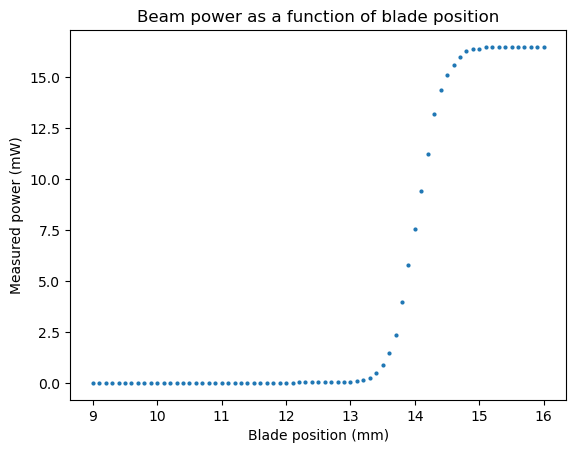

In [612]:
plt.scatter(power_data[0], power_data[1], s=4)
plt.title("Beam power as a function of blade position")
plt.xlabel("Blade position (mm)")
plt.ylabel("Measured power (mW)")

We notice a large nearly flat region at the start of our data (when only low power parts of the beam were revealed), which we can remove without much harm. The position of 12 mm (where it stops being so flat all the time) occurs at index 32 of the CSV, so we drop all indices before that.

In [613]:
power_data_x_less = power_data[0][32:]
power_data_P_less = power_data[1][32:]

print(power_data_x_less)

power_data_new = np.array([power_data_x_less,power_data_P_less])

[12.2 12.3 12.4 12.5 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5
 13.6 13.7 13.8 13.9 14.  14.1 14.2 14.3 14.4 14.5 14.6 14.7 14.8 14.9
 15.  15.1 15.2 15.3 15.4 15.5 15.6 15.7 15.8 15.9 16. ]


Text(0, 0.5, 'Measured power (mW)')

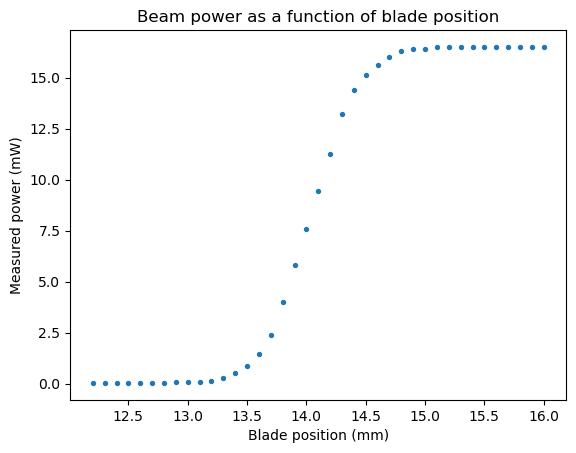

In [614]:
plt.scatter(power_data_new[0], power_data_new[1], s=8)
plt.title("Beam power as a function of blade position")
plt.xlabel("Blade position (mm)")
plt.ylabel("Measured power (mW)")

After that, it's useful to have the data centered at $x=0$. The expected form of a Gaussian is easiest to express in this form, and having the
center of the laser beam at $x=0$ makes enough sense to warrant going through the (very minimal) trouble. We just want to move the mean position to $x=0$, so we substract the mean off of every datapoint. By doing so, the $x$-axis no longer measures "blade position," but the position relative
to the center of the beam, which I will either call ``beam position'' or refer to as the blade position relative to beam center.

In [615]:
power_data_new[0] = power_data_new[0] - power_data_new[0].mean()

Text(0, 0.5, 'Measured power (mW)')

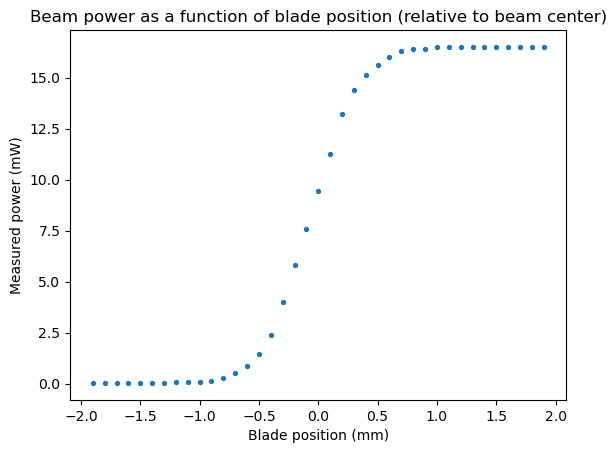

In [616]:
plt.scatter(power_data_new[0], power_data_new[1], s=8)
plt.title("Beam power as a function of blade position (relative to beam center)")
plt.xlabel("Blade position (mm)")
plt.ylabel("Measured power (mW)")

The goal is to find the derivative of this function, but attempts to do so numerically are kinda rough tbh:

## Attempts to do so numerically

We find the derivative numerically using numpy's gradient function.

In [617]:
dP_dx = np.gradient(power_data_new[1], power_data_new[0])

Text(0, 0.5, 'Intensity $dP/dx$ (mW/mm)')

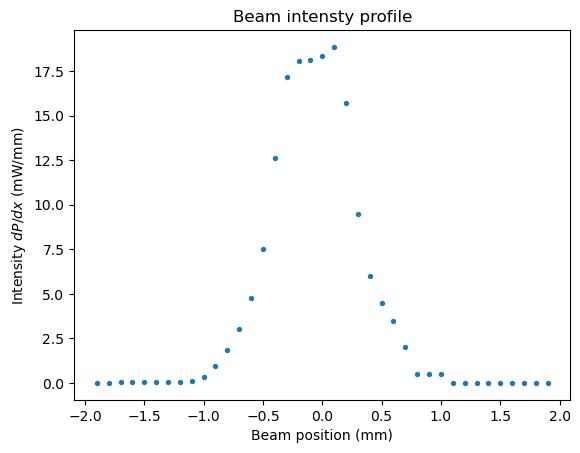

In [618]:
plt.scatter(power_data_new[0],dP_dx, s=8)
plt.title("Beam intensty profile")
plt.xlabel("Beam position (mm)")
plt.ylabel(r'Intensity $dP/dx$ (mW/mm)')

## A better way: Fitting a logistic function

We'll fit a logistic function to our data, get an analytical symbolic expression, and calculate the derivative with SymPy (same as doing it by hand but less prone to user error).

In [619]:
def logistic(x, x0, L, k):
    return L / (1 + np.exp(-k*(x-x0)))

In [620]:
fitted_logistic_coeff, covariance = curve_fit(logistic, power_data_new[0], power_data_new[1], p0=[0,16,1])

Text(0, 0.5, 'Measured power (mW)')

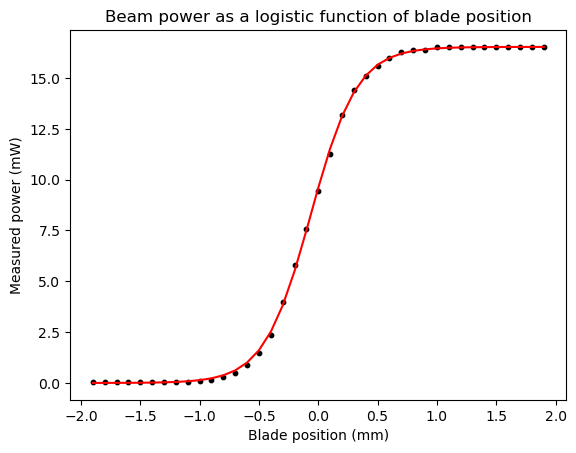

In [621]:
plt.scatter(power_data_new[0], power_data_new[1], s=10, color='black')
plt.plot(power_data_new[0], logistic(power_data_new[0], *fitted_logistic_coeff), 'r-',label='Fitted function')
plt.title("Beam power as a logistic function of blade position")
plt.xlabel("Blade position (mm)")
plt.ylabel("Measured power (mW)")

In [622]:
print(*fitted_logistic_coeff)

-0.0638836928974384 16.527983115633536 5.107269322550177


The logistic function that fits our data has $L = 16.528$, $x_0 = -0.0639$, and $k=5.10727$, and can be written explicitly as:

\begin{align*}
f(x) = \frac{16.528}{1+e^{-5.10727(x+0.0639)}}
\end{align*}

The derivative is:

\begin{align*}
 f(x) &= 16.528(1+e^{-5.10727(x+0.0639)})^{-1} \\
 f'(x) &= -16.528(1 + e^{-5.10727(x+0.0639)})^{-2}\left(-5.10727e^{-5.10727(x+0.0639)}\right) \\
 &= \frac{Lke^{-k(x-x_0)}}{\left(1 + e^{-k(x-x_0)}\right)^{2}}
\end{align*}

In [623]:
def dP_dx_fit(x, x0_fit, L_fit, k_fit):
    return L_fit*k_fit * np.exp(-k_fit*(x-x0_fit)) / (1 + np.exp(-k_fit*(x-x0_fit)))**2

In [624]:
dP_dx_fitted = np.array([])
x = power_data_new[0]
length = x.size

for i in range(length):
    temp = x[i]
    dP_dx_fitted = np.append(dP_dx_fitted, dP_dx_fit(temp, *fitted_logistic_coeff))

print(dP_dx_fitted)

[7.14037549e-03 1.18981096e-02 1.98245003e-02 3.30272304e-02
 5.50112457e-02 9.15967212e-02 1.52425341e-01 2.53405738e-01
 4.20611300e-01 6.96293780e-01 1.14761538e+00 1.87783811e+00
 3.03657849e+00 4.81749926e+00 7.41557101e+00 1.08983862e+01
 1.49689028e+01 1.87456733e+01 2.09247248e+01 2.05514068e+01
 1.77994863e+01 1.38189387e+01 9.85013697e+00 6.60395370e+00
 4.24852683e+00 2.66131997e+00 1.63940670e+00 9.99519478e-01
 6.05561977e-01 3.65482470e-01 2.20075966e-01 1.32335163e-01
 7.95087623e-02 4.77459652e-02 2.86633807e-02 1.72043999e-02
 1.03253423e-02 6.19642317e-03 3.71843919e-03]


We now have the beam intensity ($dP/dx$) as a function of position, and can plot the intensity profile for ANY $x$ (not just those in our dataset). Our data (after moving the mean to $x=0$) ranges between -2 mm and 2 mm, so we'll do the same here. We'll also, for posterity's sake, include
the derivative calculated at our datapoints in black. This isn't any sort of indication of fit, as the black dots are just a subset of the red curve, but I figure it's good to have.

Text(0, 0.5, 'Intensity profile ($dP/dx$) (W/m)')

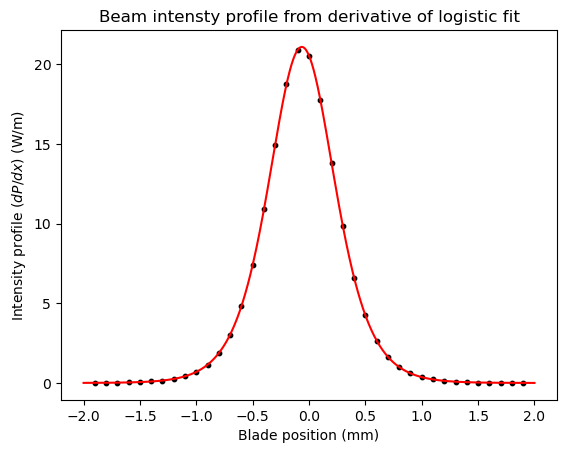

In [625]:
intensity_positions = np.linspace(-2,2,1000)

plt.plot(intensity_positions,dP_dx_fit(intensity_positions, *fitted_logistic_coeff), color='red')
plt.scatter(power_data_new[0],dP_dx_fitted, color='black', s=10)
plt.title("Beam intensty profile from derivative of logistic fit")
plt.xlabel("Blade position (mm)")
plt.ylabel(r'Intensity profile ($dP/dx$) (W/m)')

We'll also compare this to the derivative calculated directly from the data, which suffered from some noise.

Text(0, 0.5, 'Intensity profile ($dP/dx$) (W/m)')

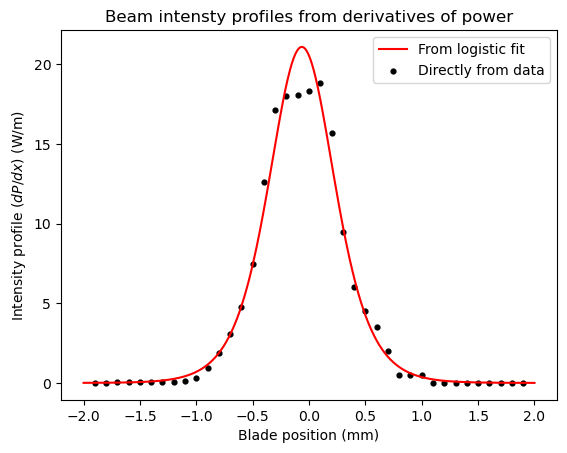

In [626]:
plt.plot(intensity_positions, dP_dx_fit(intensity_positions, *fitted_logistic_coeff), color='red', label='From logistic fit')
plt.scatter(power_data_new[0],dP_dx, color='black', s=12, label='Directly from data')
plt.title("Beam intensty profiles from derivatives of power")
plt.legend()
plt.xlabel("Blade position (mm)")
plt.ylabel(r'Intensity profile ($dP/dx$) (W/m)')

## Maybe an EVEN better way: Fitting an error function

The error function is the actual shape of our data. We're expecting the beam to be Gaussian, and power is the integral under our beam profile. The error function is DEFINED as the integral of something Gaussian. A typical Gaussian parameterized beam profile is given (by Wikipedia) as:

\begin{align*}
    G(x) = A \text{ exp}\left(\frac{-(x-x_0)^2}{2w^2}\right)
\end{align*}

where $A$ is the amplitude, $x_0$ is the center of the beam, and $w$ is the RMS width or 'standard deviation'.

In [627]:
def gauss_integrand(x, x0, A, w):
    return A*np.exp(-(x-x0)**2 / (2*w**2)) 

def error_func(x,x0,A,w):
    # This integral should theoretically start at -infinity, but we know its basically 0 out there so we start closer to eliminate
    # numerical risk. That's the -3. We would also integrate up to x, but our 'x' is a numpy array and scipy doesn't like to deal
    # with that, so we define 
    integral_array = np.array([])
    for i in range(x.size):
        integral_value, integration_error = scipy.integrate.quad(gauss_integrand, -3, x[i], args=(x0,A,w))
        integral_array = np.append(integral_array, integral_value)
    return integral_array

In [628]:
fitted_erf_coeff, erf_covariance = curve_fit(error_func, power_data_new[0], power_data_new[1], p0=[0,16,1])

Text(0, 0.5, 'Measured power (mW)')

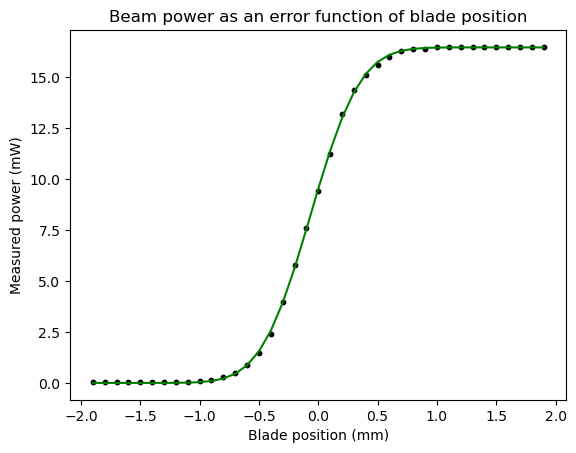

In [629]:
plt.scatter(power_data_new[0], power_data_new[1], color='black', s=10)
plt.plot(power_data_new[0], error_func(power_data_new[0], *fitted_erf_coeff), color='green')
plt.title("Beam power as an error function of blade position")
plt.xlabel("Blade position (mm)")
plt.ylabel("Measured power (mW)")

A nice thing about this method is that we no longer need to calculate a derivative at all! Our fitting process fits the INTEGRAL of a Gaussian function (which is an error function, cousins at least) to our data, and by doing so we already have the parameters of the Gaussian itself. The plot above shows how remarkably strong a fit this is to our data.

We can, of course, determine the functional form of our Gaussian (from our data) from our fit parameters:

In [630]:
print(fitted_erf_coeff)

[-0.06561682 19.9077999   0.33019906]


So we have $x_0 = -0.065617$, $A = 19.9078$, and $w=0.3302$. The Gaussian function is then:

\begin{align*}
    G(x) = 19.9078 \text{ exp}\left(\frac{-(x+0.065617)^2}{2(0.3302)^2}\right) \\
    G(x) = 19.9078 \text{ exp}\left( -4.5858(x+0.065617)^2 \right) \\
\end{align*}

We now want to visualize our Gaussian:

Text(0, 0.5, 'Intensity profile ($dP/dx$) (W/m)')

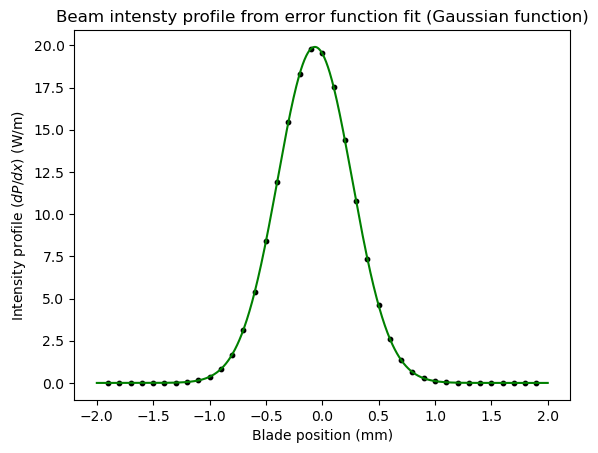

In [631]:
plt.plot(intensity_positions, gauss_integrand(intensity_positions, *fitted_erf_coeff), color='green')
plt.scatter(power_data_new[0], gauss_integrand(power_data_new[0], *fitted_erf_coeff), color='black', s=10)
plt.title("Beam intensty profile from error function fit (Gaussian function)")
plt.xlabel("Blade position (mm)")
plt.ylabel(r'Intensity profile ($dP/dx$) (W/m)')

## Comparing all three: direct derivative, logistic fit (and explicit derivative), error function fit (and implicit Gaussian)

It's hard to say which of these three is "correct" as we don't have a true value to compare to. The Gaussian fit is the most theoretically sound, assuming a Gaussian distribution of beam intensity. The direct derivatives method has the least possibility of buildup of numerical error, and despite the clear inaccuracies near the peak, the "sides" of the distribution could very well be quite accurate. The logistic fit is the worst of both worlds, despite being my "breakthrough" for this analysis. Despite looking logistic, our initial data is definitionally an error function (integral of Gaussian intensity profile). There are a large class of functions known as sigmoids that have the same sort of shape, and any one of them could be fit to roughly match our data, but the correct choice is an error function.

To compare the three visually, we'll plot each of them on the graph below. Note that we'll be performing a Gaussian fit on the the direct-derivative data. This is different than the error function fit. That fits the integral, (our actual data), this is fitting to the computed derivative curve.

In [632]:
fitted_deriv_coeff, deriv_covariance = curve_fit(gauss_integrand, power_data_new[0], dP_dx, p0=[0,15,1])

In [638]:
beam_profile_deriv = gauss_integrand(intensity_positions, *fitted_deriv_coeff)
beam_profile_logistic = dP_dx_fit(intensity_positions, *fitted_logistic_coeff)
beam_profile_errorfunc = gauss_integrand(intensity_positions, *fitted_erf_coeff)

Text(0, 0.5, 'Intensity profile ($dP/dx$) (W/m)')

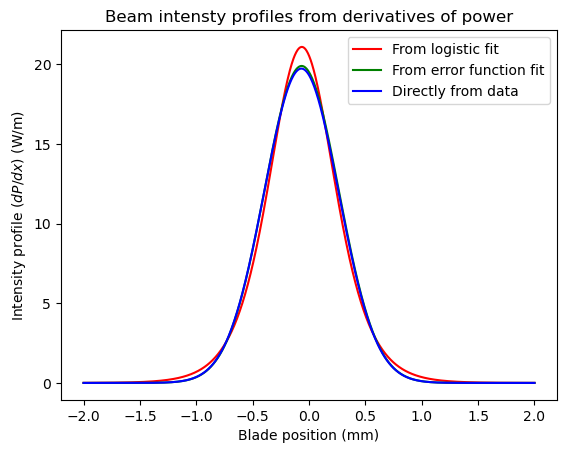

In [639]:
plt.plot(intensity_positions, beam_profile_logistic, color='red', label='From logistic fit')
plt.plot(intensity_positions, beam_profile_errorfunc, color='green', label='From error function fit')
plt.plot(intensity_positions, beam_profile_deriv, color='blue', label='Directly from data')
plt.title("Beam intensty profiles from derivatives of power")
plt.legend()
plt.xlabel("Blade position (mm)")
plt.ylabel(r'Intensity profile ($dP/dx$) (W/m)')

We see that the Gaussian fit on our numerical derivative data is nearly identical to the error function fit on our power data. This makes sense in theory, as they are essentially two different paths to do the same thing: one fit and one "manual" computation to achieve a Gaussian beam profile. For the blue curve, we manually compute the derivatives and then fit a Gaussian curve to that data. For the green curve (underneath) we perform the error function fit on our postion-power data, and then manually find the Gaussian from that. If one is walking north then east, the other is walking east then north. As we predicted, the logistic fit is further from the other two.

## The reason I actually did this: determining the size of the beam

There are a number of different ways to define the size of a laser beam. From what I've found, the most common are the $1/e^2$ diameter and the FWHM (full width at half maximum). To get either, we'll define a function to find the positions associated with difference percentages of intensity. The 1/e^2 diameter uses an intensity that is 1/e^2 times the maximum intensity, corresponding to ~13.53 percent. The FWHM is at half maximum, so the intensity percentage is 50 percent.

This function will take the intensity_percentage, the FUNCTION defining the beam_profile (dP_dx_fit for the logistic fit, gauss_integrand for both the error function fit and the direct derivative fit), and the fit parameters associated with each (fitted_xxxxx_coeff for all three, with the middle
replaced with either logistic, error, or deriv). We use the asterisk at the front within the function definition to unpack the array of coefficients so it matches the parameters of the particular function used.

In [ ]:

def find_diameter_given_intensity_percentage(intensity_percentage, beam_func, beam_params):
    beam_profile = beam_func(intensity_positions, *beam_params)
    max = beam_profile.max()
    desired_value = max*intensity_percentage
    # The goal is to find the x-values at which this value of intensity occurs. If we take our beam profile and subtract the desired value, 
    # then the points we're looking for will become x-intercepts (since their intensity is now 0). If we locate where those zeros are, we have
    # the x-values at which the desired value occurs.
    def func_to_solve(x, params):
        return beam_func(x, *params) - desired_value

    # Locates index where the sign of beam_profile - desired value changes
    idx = np.argwhere(np.diff(np.sign(beam_profile - desired_value))).flatten()
    negative_root = intensity_positions[idx[0]]
    positive_root = intensity_positions[idx[1]]

    return positive_root - negative_root

1.3213213213213215

In [650]:
logistic_e_square_diameter = find_diameter_given_intensity_percentage(1/(np.e**2), dP_dx_fit, fitted_logistic_coeff)
error_e_square_diameter = find_diameter_given_intensity_percentage(1/(np.e**2), gauss_integrand, fitted_erf_coeff)
deriv_e_square_diameter = find_diameter_given_intensity_percentage(1/(np.e**2), gauss_integrand, fitted_deriv_coeff)

logistic_FWHM_diameter = find_diameter_given_intensity_percentage(1/2, dP_dx_fit, fitted_logistic_coeff)
error_FWHM_diameter = find_diameter_given_intensity_percentage(1/2, gauss_integrand, fitted_erf_coeff)
deriv_FWHM_diameter = find_diameter_given_intensity_percentage(1/2, gauss_integrand, fitted_deriv_coeff)

In [ ]:
print(f"Logistic FWHM: {logistic_FWHM_diameter:0.2f} mm")
print(f"Error fit FWHM: {error_FWHM_diameter:0.2f} mm")
print(f"Gaussian derivative FWHM: {deriv_FWHM_diameter:0.2f} mm")

print('')

print(rf"Logistic 1/e^2 diameter: {logistic_e_square_diameter:0.2f} mm")
print(rf"Error fit 1/e^2 diameter: {error_e_square_diameter:0.2f} mm")
print(rf"Deriv 1/e^2 diameter: {deriv_e_square_diameter:0.2f} mm")

Logistic FWHM: 0.69 mm
Error fit FWHM: 0.78 mm
Gaussian derivative FWHM: 0.78 mm

Logistic $1/e^2$ diameter: 1.30 mm
Error fit $1/e^2$ diameter: 1.32 mm
Deriv $1/e^2$ diameter: 1.32 mm
